In [1]:
import random
import xml.etree.ElementTree as ET

import pandas
from plotnine import *
import requests

%load_ext rpy2.ipython

In [2]:
# I would rather this be a static variable in the include_sample method, but I haven't found
# a clean way to do that
SAMPLES_SEEN = set()

def include_sample(experiment_package):
    sample = experiment_package.find('./SAMPLE')
    
    cases = 0
    controls = 0
    invalid = 0

    sample = experiment_package.find('./SAMPLE')

    # If sample has no sample information, don't include it
    if sample is not None:
        accession = sample.attrib['accession']
        # If this sample is a duplicate, don't include it
        if accession in SAMPLES_SEEN:
            return False
        else:
            SAMPLES_SEEN.add(accession)
    else:
        return False

    # If a sample is in dbGaP, we don't have access to it, so don't include it
    study = experiment_package.find('./STUDY')
    if study is not None:
        center_name = study.attrib['center_name']
        if center_name == 'dbGaP':
            return False

    # If a sample isn't labeled as a case or control, don't include it
    category = experiment_package.attrib['category']
    if category != 'case' and category != 'control':
        return False
            
    return True

In [3]:
def get_study_center_name(experiment_package):
    study = experiment_package.find('./STUDY')
    if 'center_name' in study.attrib:
        study_center_name = study.attrib['center_name']
        return study_center_name

def get_experiment_center_name(experiment_package):
    experiment = experiment_package.find('./EXPERIMENT')
    if 'center_name' in experiment.attrib:
        experiment_center_name = experiment.attrib['center_name']
        return experiment_center_name

def get_bases_read_gb(experiment_package):
    bases_object = experiment_package.find('./RUN_SET/RUN')
    if bases_object is not None:
        if 'total_bases' in bases_object.attrib:
            bases_read = int(bases_object.attrib['total_bases'])
            return bases_read / 1e9

In [4]:
sample_data = {'study_center_name': [], 
               'experiment_center_name': [],
               'bases_read_gb': [],
              }

tree = ET.parse('../data/tree.xml')
root = tree.getroot()

In [5]:
packages = root.findall('./EXPERIMENT_PACKAGE_SET/EXPERIMENT_PACKAGE')

count = 0
for experiment_package in packages:
    if include_sample(experiment_package):
        sample_data['study_center_name'].append(get_study_center_name(experiment_package))
        sample_data['experiment_center_name'].append(get_experiment_center_name(experiment_package))
        sample_data['bases_read_gb'].append(get_bases_read_gb(experiment_package))
        count += 1
print(count)

10656


In [6]:
samples_df = pandas.DataFrame(sample_data)
samples_df.head()

,study_center_name,experiment_center_name,bases_read_gb
0,GEO,None,0.421016
1,GEO,None,0.233445
2,GEO,None,0.570866
3,GEO,None,0.386536
4,GEO,None,0.278808


## Centers
---
There are multiple 'center' attributes found in the metadata, including 'study_center_name' and 'experiment_center_name'. I assume that these are synonyms, but it is unclear exactly what they mean. As a result, it is hard to draw much information from these fields

In [7]:
samples_df['study_center_name'].value_counts()

GEO                                                                                          8837
BioProject                                                                                    827
BCCAGSC                                                                                       130
Max Delbrck Center for Molecular Medicine, Berlin-Buch, Germany                               128
Department of Cell and Molecular Biology (CMB), Karolinska Institutet, Stockholm, Sweden.     109
Wellcome Sanger Institute                                                                      96
Science for Life Laboratory, Stockholm, Sweden                                                 95
French National League Against Cancer - Research Dept - CIT Group                              64
School of Computer Sciences University of Birmingham                                           47
UNIVERSITY OF SHEFFIELD                                                                        46
DEPARTMENT OF CELL A

In [8]:
samples_df['experiment_center_name'].value_counts()

GEO                                                                                          3753
BCCAGSC                                                                                       130
UT-MGS                                                                                        116
Department of Cell and Molecular Biology (CMB), Karolinska Institutet, Stockholm, Sweden.     109
Science for Life Laboratory, Stockholm, Sweden                                                 95
French National League Against Cancer - Research Dept - CIT Group                              64
SCHOOL OF COMPUTER SCIENCES UNIVERSITY OF BIRMINGHAM                                           44
DEPARTMENT OF CELL AND MOLECULAR BIOLOGY, KAROLINSKA INSTITUTET                                38
University of North Carolina - Chapel Hill                                                     34
Garvan Institute of Medical Research,                                                          29
SCIENCE FOR LIFE LAB

## Bases Read Distribution
---
One field frequently found in the metadata is the 'bases_read' field. This appears to be the total amount of sequencing done for each sample. While this is not exactly the same as the sequencing depth, it gives a rough idea of how deeply sequenced the average sample is in the dataset.

/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 109'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_bin : Removed 2 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels)

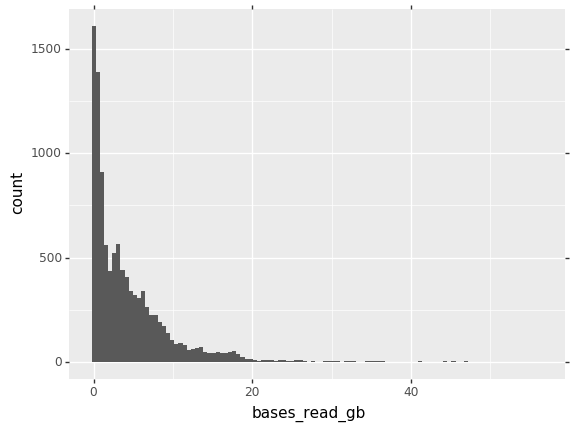

<ggplot: (8726563603425)>

In [9]:
ggplot(samples_df, aes(x='bases_read_gb')) + geom_histogram()

In [10]:
studies = root.findall('EXPERIMENT_PACKAGE_SET/EXPERIMENT_PACKAGE/STUDY')

study_accessions = [study.get('accession') for study in studies]
# Remove duplicate accessions
study_accessions = list(set(study_accessions))
print(study_accessions[:5])

['SRP027364', 'SRP040998', 'SRP062966', 'SRP017262', 'SRP067502']


In [11]:
%%R

library(recount)
metadata <- all_metadata()
write.table(metadata, '~/Desktop/brd-net/data/recount_metadata.csv', sep='\t', row.names=FALSE)

/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: SummarizedExperiment

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: GenomicRanges

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinter

In [12]:
# Load the metadata from calling recount's all_metadata function
recount2_metadata = pandas.read_csv('../data/recount_metadata.csv', sep='\t')

recount2_study_accessions = set(recount2_metadata['project'])
print(len(recount2_study_accessions))

3219


In [13]:
# Keep only the accessions that can be downloaded from recount2
study_accessions = [accession for accession in study_accessions if accession in recount2_study_accessions]
print(len(study_accessions))

239


In [14]:
data = requests.get('http://metasra.biostat.wisc.edu/api/v01/samples.json?study={}'.format(study_accessions[0]))
print(data.json())

{'sampleCount': 11, 'terms': [{'sampleCount': 11, 'dterm': {'name': 'disease of cellular proliferation', 'ids': ['DOID:14566']}}, {'sampleCount': 11, 'dterm': {'name': 'neoplasm', 'ids': ['EFO:0000616']}}, {'sampleCount': 11, 'dterm': {'name': 'thyroid gland', 'ids': ['UBERON:0002046']}}], 'skip': 0, 'studyCount': 1, 'studies': [{'sampleCount': 11, 'study': {'title': 'Novel kinase fusion oncogenes in post-Chernobyl radiation-induced pediatric thyroid cancers', 'id': 'SRP027364', 'recountId': 'SRP027364'}, 'sampleGroups': [{'type': {'type': 'tissue', 'conf': 0.8003023621877458}, 'samples': [{'experiments': [{'runs': ['SRR934363'], 'id': 'SRX322312'}], 'name': 'thyroid tissue', 'id': 'SRS457475'}, {'experiments': [{'runs': ['SRR934364'], 'id': 'SRX322313'}], 'name': 'thyroid tissue', 'id': 'SRS457477'}, {'experiments': [{'runs': ['SRR934360'], 'id': 'SRX322309'}], 'name': 'thyroid tissue', 'id': 'SRS457474'}, {'experiments': [{'runs': ['SRR934361'], 'id': 'SRX322310'}], 'name': 'thyroid 

In [15]:
id_to_studies = {}
id_to_samples = {}
id_to_name = {}

total_samples = 0

for accession in study_accessions:
    data = requests.get('http://metasra.biostat.wisc.edu/api/v01/samples.json?study={}'.format(accession)).json()
    
    total_samples += data['sampleCount']
    
    for term in data['terms']:
        term_name = term['dterm']['name']
        term_ids = term['dterm']['ids']
        
        disease = False
        disease_id = None
        for id_ in term_ids:
            if 'DOID' in id_:
                disease_id = id_
                disease = True
                break
                
        if not disease:
            continue
        
        if disease_id in id_to_studies:
            id_to_studies[disease_id] += 1
            id_to_samples[disease_id] += term['sampleCount']
        else:
            id_to_studies[disease_id] = 1
            id_to_samples[disease_id] = term['sampleCount']
            id_to_name[disease_id] = term_name            

In [16]:
disease_dict = {}
for id_ in id_to_studies:
    disease_dict[id_] = [id_to_studies[id_], id_to_samples[id_], id_to_name[id_]]

disease_df = pandas.DataFrame.from_dict(disease_dict, orient='index', columns=['num_studies', 'num_samples', 'name'])

all_doids = set(id_to_studies.keys())

disease_df.sort_values('num_samples').head()

,num_studies,num_samples,name
DOID:12849,1,6,autistic disorder
DOID:1974,1,6,adenosarcoma
DOID:11722,1,6,myotonic dystrophy type 1
DOID:397,1,8,restrictive cardiomyopathy
DOID:0050749,1,8,peripheral T-cell lymphoma


In [17]:
DOID_to_descendants = {}
def get_descendants(doid):
    '''This function calls the Disease Ontology API to find all descendants for a given doid'''
    if doid in DOID_to_descendants:
        return DOID_to_descendants[doid]
    
    
    descendants = []
    data = requests.get('http://www.disease-ontology.org/api/metadata/{}'.format(doid)).json()
    
    if 'children' not in data:
        return []
    
    for child in data['children']:
        child_doid = child[1]
        descendants.append(child_doid)
        
        # recursively traverse the ontology
        child_descendants = get_descendants(child_doid)
        descendants.extend(child_descendants)
        
    DOID_to_descendants[doid] = descendants
    return descendants

In [18]:
print(len(get_descendants('DOID:4')))

9476


In [20]:
# Iterate through all terms found in the data, and only add them to a list if 
# none of their descendants are in the study

leaf_ids = []

for doid in id_to_name:
    descendants = get_descendants(doid)
    descendant_in_study = False
    for descendant in descendants:
        if descendant in all_doids:
            descendant_in_study = True
            break
    
    if not descendant_in_study:
        leaf_ids.append(doid)

# These aren't necessarily leaves of the ontology, but they are don't have any descendants
# in this dataset, so we'll call them leaves
print(len(leaf_ids))

102


In [21]:
disease_df.loc[leaf_ids].head()

,num_studies,num_samples,name
DOID:684,8,275,hepatocellular carcinoma
DOID:4660,1,117,indolent systemic mastocytosis
DOID:9074,1,117,systemic lupus erythematosus
DOID:8567,1,23,Hodgkin's lymphoma
DOID:1040,2,89,chronic lymphocytic leukemia


In [22]:
print(total_samples)
print(disease_df.loc[leaf_ids]['num_samples'].sum())

13437
8877


In [25]:
# Select studies at random from the list of all samples
# If the study has one of the leaf ids, add it to the list
# Stop once enough samples are included (~1000 valid samples)

# In a script, you would put the random seed at the top. Since each cell can be
# rerun in a notebook, manually setting the seed within each cell with a random
# call ensures that you get the same results regardless of the order in which
# the cells are run
random.seed(42)

leaf_set = set(leaf_ids)

samples_drawn = 0
plier_sample_accessions = []

# Select samples in a random order
indices = list(range(len(study_accessions)))
random.shuffle(indices)

for index in indices:
    study = study_accessions[index]
    data = requests.get('http://metasra.biostat.wisc.edu/api/v01/samples.json?study={}'.format(study)).json()

    for term in data['terms']:
        term_ids = term['dterm']['ids']

        use_sample = False
        for id_ in term_ids:
            if id_ in leaf_set:
                plier_sample_accessions.append(study)
                
                samples_drawn += data['sampleCount']
                use_sample = True
                break
        
        if use_sample:
            break
            
    # Some of the samples will turn out to be invalid, so we use 3000 here instead of
    # a proportion of the total number of samples
    if samples_drawn > 3000:
        break
        
print(plier_sample_accessions)

['SRP028291', 'SRP039591', 'ERP009437', 'SRP034698', 'SRP035988', 'SRP063460', 'SRP052056', 'SRP033566', 'SRP057118', 'SRP056293', 'DRP000987', 'SRP056612', 'SRP052896', 'SRP011924', 'ERP010889', 'SRP012656', 'SRP063493', 'SRP014020', 'SRP063838', 'SRP017262', 'SRP015640', 'SRP007825', 'SRP011422', 'SRP062966', 'SRP039694', 'SRP003611', 'SRP065559', 'SRP063661', 'SRP031459', 'SRP058667', 'SRP051844', 'SRP007946', 'SRP029880', 'SRP051825', 'SRP053296', 'SRP028554', 'SRP014428', 'SRP048801', 'SRP065812', 'SRP000941', 'SRP007947', 'SRP015668', 'SRP007461', 'SRP023262', 'SRP055438', 'SRP043391', 'SRP029434', 'SRP012167', 'SRP033095', 'SRP006575', 'SRP051765', 'SRP012546', 'SRP056477', 'SRP041538', 'SRP041736']


In [26]:
# Get all runs from xml
experiment_packages = root.findall('EXPERIMENT_PACKAGE_SET/EXPERIMENT_PACKAGE')

plier_healthy = []
plier_disease = []
classifier_healthy = []
classifier_disease = []

recount_study_set = set(study_accessions)

for experiment_package in experiment_packages:
    study_accession = experiment_package.find('STUDY').get('accession')
    in_plier_set = study_accession in plier_sample_accessions
    
    case_control_status = experiment_package.get('category')
    
    if case_control_status == 'invalid' or study_accession not in recount_study_set:
        continue
    
    
    runs = experiment_package.findall('RUN_SET/RUN/IDENTIFIERS/PRIMARY_ID')
    for run in runs:
        run_id = '.'.join([study_accession, run.text])
        
        if case_control_status == 'control':
            if in_plier_set:
                plier_healthy.append(run_id)
            else:
                classifier_healthy.append(run_id)
        elif case_control_status == 'case':
            if in_plier_set:
                plier_disease.append(run_id)
            else:
                classifier_disease.append(run_id)
      

In [27]:
print(len(plier_healthy))
print(len(plier_disease))
    
print(len(classifier_healthy))
print(len(classifier_disease))

print(plier_healthy[:5])

357
882
3290
3970
['SRP041538.SRR1265536', 'SRP041538.SRR1265535', 'SRP041538.SRR1265534', 'SRP041538.SRR1265495', 'SRP041538.SRR1265533']


## Downloading Data
---
We'll now switch to R, because the only programmatic way to access recount2 data is through the recount bioconductor package. Thanks to the magic of rpy, we can use the list of run accessions we generated in the R code below.

The R portion of this notebook is based heavily on Qiewen Hu's script [here](https://github.com/greenelab/rheum-plier-data/blob/master/recount2/1-get_all_recount_dataset.R)

In [28]:
%%R 
`%>%` <- dplyr::`%>%`
library(recount)
library(xml2)

In [29]:
%%R
# Get RPKM value for each gene - adapted from recount package
getRPKM <- function(rse, length_var = 'bp_length', mapped_var = NULL) { 
  # Computes the RPKM value for each gene in the sample.
  #
  # Args: 
  #  rse: A RangedSummarizedExperiment-class object in recount package
  #  length_var: A length 1 character vector with the column name from rowData(rse) that has
  #              the coding length. For gene level objects from recount this is bp_length. If
  #              NULL, then it will use width(rowRanges(rse)) which should be used for exon RSEs.
  #  mapped_var: A length 1 character vector with the column name from colData(rse) that has
  #              the number of reads mapped. If NULL (default) then it will use the column 
  #              sums of the counts matrix
  # Returns:
  #   RPKM value for each sample
  if(!is.null(mapped_var)){
    mapped <- colData(rse)[, mapped_var] 
  } else {
    mapped <- colSums(assays(rse)$counts) 
  } 
  bg <- matrix(mapped, ncol = ncol(rse), nrow = nrow(rse), byrow = TRUE) 
  if(!is.null(length_var)){
    len <- rowData(rse)[, length_var] 
  } else {
    len <- width(rowRanges(rse))
  }
  wid <- matrix(len, nrow = nrow(rse), ncol = ncol(rse), byrow = FALSE) 
  rpkm <- assays(rse)$counts / (wid/1000) / (bg/1e6) 
  return(rpkm)
} 

getExperimentDf <- function(rpkm.list, id.vector) {
  # Extracts the runs found in id.vector from a list of dataframes, and combines'
  # them into a single large dataframe
    
  rpkm.df <- do.call(base::cbind, c(rpkm.list, by = "id"))
  subset.df <- rpkm.df %>% dplyr::select(dplyr::one_of(id.vector))
  subset.df <- tibble::rownames_to_column(subset.df, "ENSG")
  
  return(subset.df)
}

In [30]:
%%R

data.dir <- file.path("../data")
recount.dir <- file.path(data.dir, "recount")
dir.create(recount.dir, recursive = TRUE, showWarnings = FALSE)

In [33]:
%%R -i study_accessions

included.study.list <- study_accessions

# Download all recount2 samples in included.study.list that are available
# This takes a while
lapply(included.study.list, 
       function(x) tryCatch(download_study(x, type = "rse-gene", 
                                           outdir = file.path(recount.dir, x)),
                            error= function(e) NULL))

/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:27:51 downloading file rse_gene.Rdata to ../data/recount/SRP027364

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:27:52 downloading file rse_gene.Rdata to ../data/recount/SRP040998

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:27:53 downloading file rse_gene.Rdata to ../data/recount/SRP062966

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:27:57 downloading file rse_gene.Rdata to ../data/recount/SRP017262

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:

/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:29:03 downloading file rse_gene.Rdata to ../data/recount/SRP065491

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:29:05 downloading file rse_gene.Rdata to ../data/recount/SRP001371

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:29:08 downloading file rse_gene.Rdata to ../data/recount/SRP002274

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:29:09 downloading file rse_gene.Rdata to ../data/recount/SRP017789

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:

/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:30:11 downloading file rse_gene.Rdata to ../data/recount/SRP007825

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:30:13 downloading file rse_gene.Rdata to ../data/recount/SRP055513

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:30:17 downloading file rse_gene.Rdata to ../data/recount/SRP029889

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:30:18 downloading file rse_gene.Rdata to ../data/recount/SRP029899

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:

/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:31:17 downloading file rse_gene.Rdata to ../data/recount/SRP057087

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:31:20 downloading file rse_gene.Rdata to ../data/recount/SRP028594

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:31:23 downloading file rse_gene.Rdata to ../data/recount/SRP064316

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:31:24 downloading file rse_gene.Rdata to ../data/recount/SRP059170

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:

/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:32:26 downloading file rse_gene.Rdata to ../data/recount/SRP007947

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:32:28 downloading file rse_gene.Rdata to ../data/recount/SRP025982

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:32:40 downloading file rse_gene.Rdata to ../data/recount/SRP065848

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:32:41 downloading file rse_gene.Rdata to ../data/recount/SRP056969

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:

/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:33:50 downloading file rse_gene.Rdata to ../data/recount/SRP055874

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:33:51 downloading file rse_gene.Rdata to ../data/recount/SRP058719

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:33:53 downloading file rse_gene.Rdata to ../data/recount/SRP063838

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:33:54 downloading file rse_gene.Rdata to ../data/recount/SRP045500

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:

/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:34:53 downloading file rse_gene.Rdata to ../data/recount/SRP009251

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:34:54 downloading file rse_gene.Rdata to ../data/recount/SRP063493

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:34:56 downloading file rse_gene.Rdata to ../data/recount/SRP058740

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2019-07-18 10:34:57 downloading file rse_gene.Rdata to ../data/recount/SRP045611

  warnings.warn(x, RRuntimeWarning)
/home/ben/anaconda3/envs/brdnet/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:

[[1]]
[1] "http://duffel.rail.bio/recount/v2/SRP027364/rse_gene.Rdata"

[[2]]
[1] "http://duffel.rail.bio/recount/v2/SRP040998/rse_gene.Rdata"

[[3]]
[1] "http://duffel.rail.bio/recount/v2/SRP062966/rse_gene.Rdata"

[[4]]
[1] "http://duffel.rail.bio/recount/v2/SRP017262/rse_gene.Rdata"

[[5]]
[1] "http://duffel.rail.bio/recount/v2/SRP067502/rse_gene.Rdata"

[[6]]
[1] "http://duffel.rail.bio/recount/v2/SRP033291/rse_gene.Rdata"

[[7]]
[1] "http://duffel.rail.bio/recount/v2/SRP056041/rse_gene.Rdata"

[[8]]
[1] "http://duffel.rail.bio/recount/v2/SRP041620/rse_gene.Rdata"

[[9]]
[1] "http://duffel.rail.bio/recount/v2/SRP043221/rse_gene.Rdata"

[[10]]
[1] "http://duffel.rail.bio/recount/v2/SRP028291/rse_gene.Rdata"

[[11]]
[1] "http://duffel.rail.bio/recount/v2/SRP012656/rse_gene.Rdata"

[[12]]
[1] "http://duffel.rail.bio/recount/v2/SRP055440/rse_gene.Rdata"

[[13]]
[1] "http://duffel.rail.bio/recount/v2/SRP041044/rse_gene.Rdata"

[[14]]
[1] "http://duffel.rail.bio/recount/v2/SRP047399/rse_

In [34]:
%%R

# get RPKM for each experiment and add to list
rpkm.list <- list()
for(experiment in included.study.list) {
  possibleError <- tryCatch(load(file.path(recount.dir, experiment, 'rse_gene.Rdata')), error=function(e) e)
  # If the file can't be loaded, it wasn't in recount, so we don't want to try to add it to our
  # gene expression matrix
  if (inherits(possibleError, 'error')){
    next
  }
  
  rpkm <- as.data.frame(getRPKM(rse_gene))
  rpkm$id <- rownames(rpkm)
  rpkm.list[[experiment]] <- rpkm
}

In [35]:
%%R -i plier_healthy,plier_disease,classifier_healthy,classifier_disease


# Convert our lists of strings to vectors of strings, and change their names to match
# R naming conventions
plier.healthy <- unlist(plier_healthy)
plier.disease <- unlist(plier_disease)
classifier.healthy <- unlist(classifier_healthy)
classifier.disease <- unlist(classifier_disease)

plier.healthy.df <- getExperimentDf(rpkm.list, plier.healthy)
plier.disease.df <- getExperimentDf(rpkm.list, plier.disease)
classifier.healthy.df <- getExperimentDf(rpkm.list, classifier.healthy)
classifier.disease.df <- getExperimentDf(rpkm.list, classifier.disease)

print(dim(plier.healthy.df))
print(dim(plier.disease.df))
print(dim(classifier.healthy.df))
print(dim(classifier.disease.df))

[1] 58037   349
[1] 58037   861
[1] 58037  3159
[1] 58037  2364


In [37]:
%%R

write.table(plier.healthy.df, file.path(data.dir, 'plier_healthy.tsv'), sep='\t', row.names=FALSE)
write.table(plier.disease.df, file.path(data.dir, 'plier_disease.tsv'), sep='\t', row.names=FALSE)
write.table(classifier.healthy.df, file.path(data.dir, 'classifier_healthy.tsv'), sep='\t', row.names=FALSE)
write.table(classifier.disease.df, file.path(data.dir, 'classifier_disease.tsv'), sep='\t', row.names=FALSE)